<a href="https://colab.research.google.com/github/alitheonly/PlantSeedling-/blob/main/0_25_Drop_RMSProp_All_B32_0214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      
  inflating: test/b4f7c9214.png      

In [2]:

# Import necessary libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
from glob import glob
import imageio
from keras.optimizers import RMSprop

In [3]:
!ls ../content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [4]:
data_path = '/content/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

In [5]:
images_path= '/content/train/*/*.png'
images = glob(images_path)

img_size = 224
train_images = []
train_labels = []
for i in images:
    train_images.append(cv2.resize(cv2.imread(i), (img_size, img_size))) 
    train_labels.append(i.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [6]:
train_X

array([[[[ 71,  90, 108],
         [ 75,  93, 110],
         [ 78,  95, 114],
         ...,
         [ 59,  81,  96],
         [ 51,  73,  90],
         [ 46,  67,  90]],

        [[ 71,  90, 107],
         [ 78,  94, 112],
         [ 80,  97, 116],
         ...,
         [ 27,  48,  69],
         [ 32,  50,  71],
         [ 31,  49,  73]],

        [[ 78,  99, 115],
         [ 73,  92, 110],
         [ 75,  92, 115],
         ...,
         [ 33,  49,  70],
         [ 39,  54,  72],
         [ 39,  55,  75]],

        ...,

        [[ 60,  56,  62],
         [ 55,  51,  55],
         [ 65,  60,  64],
         ...,
         [ 41,  38,  46],
         [ 38,  37,  44],
         [ 41,  39,  48]],

        [[ 60,  56,  63],
         [ 45,  41,  43],
         [ 45,  41,  40],
         ...,
         [ 45,  42,  53],
         [ 41,  38,  47],
         [ 38,  35,  43]],

        [[ 77,  72,  82],
         [ 60,  57,  62],
         [ 58,  56,  59],
         ...,
         [ 47,  46,  53],
        

In [7]:
train_Y

,0
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
...,...
4745,Charlock
4746,Charlock
4747,Charlock
4748,Charlock


In [8]:
train_Y.rename(columns={0:'species'},inplace=True)
_, train_count = np.unique(train_Y,return_counts=True)
df = pd.DataFrame(data = train_count)
a = train_Y['species'].unique()
a = a.tolist()
a.sort()
df['Index'] = a
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


In [9]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(train_Y.species)
train_label = np.array(y,dtype=np.float32)
train_label

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, train_label,test_size=0.3,random_state=7)
print((X_train.shape,X_test.shape))

((3325, 224, 224, 3), (1425, 224, 224, 3))



**Image** Normalization




In [11]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

## Image Data Generator

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

VGG Model

In [13]:

from keras.applications.vgg16 import VGG16

# Instantiate a VGG16 model with pre-trained weights

base_model= VGG16(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
base_model.trainable = False



58889256/58889256 [==============================] - 0s 0us/step


In [14]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
model.save('VGG16_other_0129.h5')

In [18]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

58.25103759765625 MB


In [19]:


# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:

# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))#,callbacks = [early_stopping,checkpoint])

Epoch 1/25
104/104 [==============================] - 149s 1s/step - loss: 2.1131 - accuracy: 0.2764 - val_loss: 1.9479 - val_accuracy: 0.2667
Epoch 2/25
104/104 [==============================] - 145s 1s/step - loss: 1.7649 - accuracy: 0.3895 - val_loss: 1.6326 - val_accuracy: 0.4575
Epoch 3/25
104/104 [==============================] - 148s 1s/step - loss: 1.5837 - accuracy: 0.4562 - val_loss: 1.4867 - val_accuracy: 0.5116
Epoch 4/25
104/104 [==============================] - 146s 1s/step - loss: 1.4685 - accuracy: 0.4902 - val_loss: 1.4538 - val_accuracy: 0.4835
Epoch 5/25
104/104 [==============================] - 146s 1s/step - loss: 1.3687 - accuracy: 0.5356 - val_loss: 1.3605 - val_accuracy: 0.5368
Epoch 6/25
104/104 [==============================] - 146s 1s/step - loss: 1.3032 - accuracy: 0.5468 - val_loss: 1.2922 - val_accuracy: 0.5530
Epoch 7/25
104/104 [==============================] - 146s 1s/step - loss: 1.2242 - accuracy: 0.5856 - val_loss: 1.2571 - val_accuracy: 0.5621

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
model.save('VGG16_other_0129.h5')

In [23]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

60.31834411621094 MB


In [24]:
#from google.colab import files
# model.save('Split Sklearn Train/Valid VGG16.h5')
#files.download('Split Sklearn Train/Valid VGG16.h5')

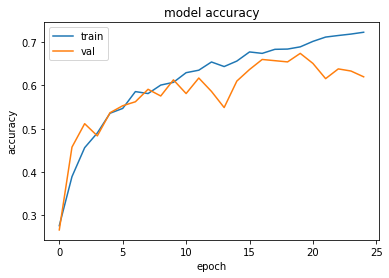

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

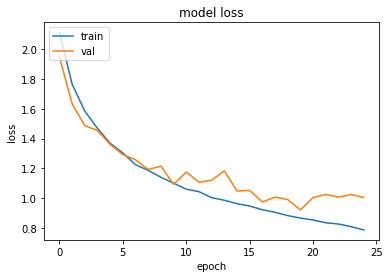

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Resnet 50

In [27]:
from keras.applications import ResNet152V2
# Instantiate a ResNet50 model with pre-trained weights
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

234545216/234545216 [==============================] - 1s 0us/step


In [28]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [29]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [31]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

232.0436248779297 MB


In [33]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
104/104 [==============================] - 156s 1s/step - loss: 1.2896 - accuracy: 0.6012 - val_loss: 0.6742 - val_accuracy: 0.7663
Epoch 2/25
104/104 [==============================] - 143s 1s/step - loss: 0.5874 - accuracy: 0.7973 - val_loss: 0.6902 - val_accuracy: 0.7965
Epoch 3/25
104/104 [==============================] - 144s 1s/step - loss: 0.4295 - accuracy: 0.8481 - val_loss: 0.6365 - val_accuracy: 0.7881
Epoch 4/25
104/104 [==============================] - 145s 1s/step - loss: 0.3239 - accuracy: 0.8875 - val_loss: 0.6594 - val_accuracy: 0.7888
Epoch 5/25
104/104 [==============================] - 143s 1s/step - loss: 0.2614 - accuracy: 0.9059 - val_loss: 0.5485 - val_accuracy: 0.8407
Epoch 6/25
104/104 [==============================] - 143s 1s/step - loss: 0.2188 - accuracy: 0.9227 - val_loss: 0.7365 - val_accuracy: 0.7895
Epoch 7/25
104/104 [==============================] - 142s 1s/step - loss: 0.1790 - accuracy: 0.9420 - val_loss: 0.7031 - val_accuracy: 0.8042

In [34]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

240.10370635986328 MB


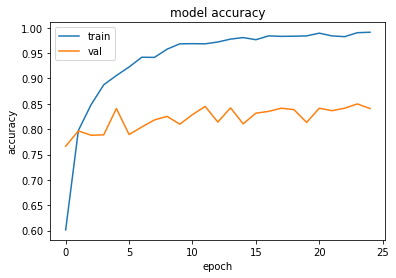

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


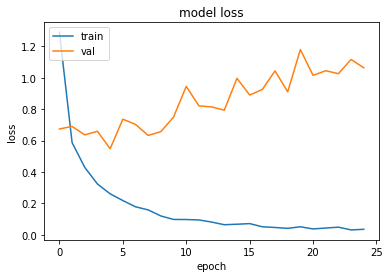

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## INCEPTION V3

In [37]:
from keras.applications import InceptionV3
# Instantiate a InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


87910968/87910968 [==============================] - 1s 0us/step


In [38]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [39]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [40]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [41]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [42]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")


92.0603256225586 MB


In [43]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 38s 325ms/step - loss: 2.0662 - accuracy: 0.4725 - val_loss: 1.1279 - val_accuracy: 0.5972
Epoch 2/25
104/104 [==============================] - 32s 307ms/step - loss: 0.9631 - accuracy: 0.6668 - val_loss: 0.9097 - val_accuracy: 0.6982
Epoch 3/25
104/104 [==============================] - 34s 323ms/step - loss: 0.7594 - accuracy: 0.7420 - val_loss: 0.7509 - val_accuracy: 0.7432
Epoch 4/25
104/104 [==============================] - 32s 313ms/step - loss: 0.6162 - accuracy: 0.7738 - val_loss: 0.6609 - val_accuracy: 0.7579
Epoch 5/25
104/104 [==============================] - 32s 306ms/step - loss: 0.5166 - accuracy: 0.8141 - val_loss: 0.6753 - val_accuracy: 0.7789
Epoch 6/25
104/104 [==============================] - 32s 309ms/step - loss: 0.4609 - accuracy: 0.8400 - val_loss: 0.6961 - val_accuracy: 0.7747
Epoch 7/25
104/104 [==============================] - 32s 306ms/step - loss: 0.4007 - accuracy: 0.8469 - val_loss: 0.8195 - val_ac

In [44]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")



100.1203384399414 MB


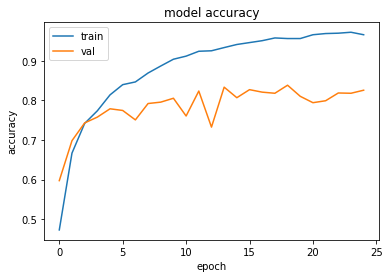

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


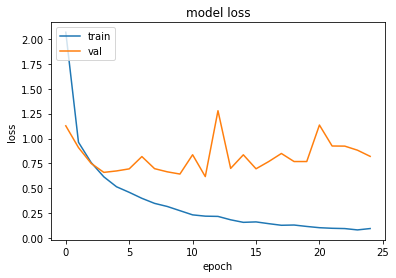

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



## XCEPTION

In [47]:
from keras.applications import Xception
# Instantiate a Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


83683744/83683744 [==============================] - 0s 0us/step


In [48]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [49]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [50]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [51]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [52]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")


88.02407836914062 MB


In [53]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 73s 682ms/step - loss: 1.3286 - accuracy: 0.5672 - val_loss: 0.9772 - val_accuracy: 0.6547
Epoch 2/25
104/104 [==============================] - 69s 667ms/step - loss: 0.7671 - accuracy: 0.7383 - val_loss: 0.8263 - val_accuracy: 0.7032
Epoch 3/25
104/104 [==============================] - 68s 660ms/step - loss: 0.5700 - accuracy: 0.7967 - val_loss: 0.6414 - val_accuracy: 0.7825
Epoch 4/25
104/104 [==============================] - 69s 663ms/step - loss: 0.4482 - accuracy: 0.8457 - val_loss: 0.6455 - val_accuracy: 0.7775
Epoch 5/25
104/104 [==============================] - 75s 722ms/step - loss: 0.3802 - accuracy: 0.8689 - val_loss: 0.6480 - val_accuracy: 0.7944
Epoch 6/25
104/104 [==============================] - 79s 763ms/step - loss: 0.3106 - accuracy: 0.8890 - val_loss: 0.7230 - val_accuracy: 0.7754
Epoch 7/25
104/104 [==============================] - 71s 681ms/step - loss: 0.2733 - accuracy: 0.9047 - val_loss: 0.8177 - val_ac

In [54]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")



96.0842514038086 MB


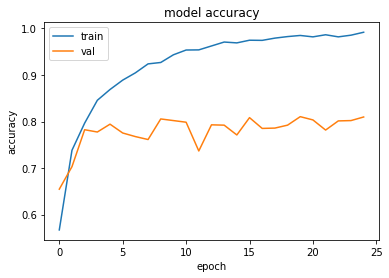

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


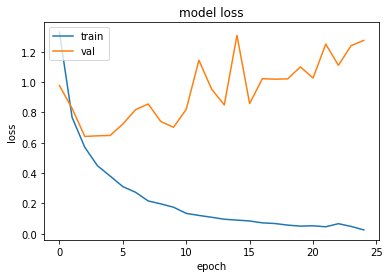

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



## **DenseNet121**

In [57]:
from keras.applications import DenseNet121
# Instantiate a DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


29084464/29084464 [==============================] - 0s 0us/step


In [58]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [59]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [60]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [61]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [62]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")


32.02588653564453 MB


In [63]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 80s 720ms/step - loss: 1.5237 - accuracy: 0.5134 - val_loss: 0.8459 - val_accuracy: 0.7088
Epoch 2/25
104/104 [==============================] - 73s 703ms/step - loss: 0.8165 - accuracy: 0.7263 - val_loss: 0.7603 - val_accuracy: 0.7228
Epoch 3/25
104/104 [==============================] - 72s 696ms/step - loss: 0.6413 - accuracy: 0.7805 - val_loss: 0.6080 - val_accuracy: 0.7923
Epoch 4/25
104/104 [==============================] - 73s 709ms/step - loss: 0.5403 - accuracy: 0.8168 - val_loss: 0.5034 - val_accuracy: 0.8175
Epoch 5/25
104/104 [==============================] - 73s 700ms/step - loss: 0.4764 - accuracy: 0.8313 - val_loss: 0.6729 - val_accuracy: 0.7558
Epoch 6/25
104/104 [==============================] - 77s 742ms/step - loss: 0.4030 - accuracy: 0.8574 - val_loss: 0.4926 - val_accuracy: 0.8084
Epoch 7/25
104/104 [==============================] - 72s 691ms/step - loss: 0.3604 - accuracy: 0.8677 - val_loss: 0.5375 - val_ac

In [64]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



36.086036682128906 MB


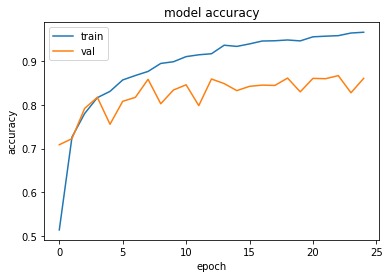

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


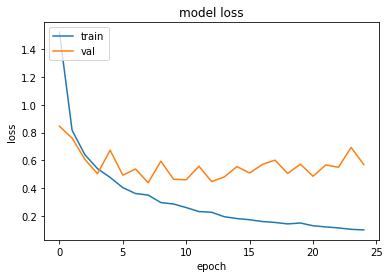

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



### MobileNetV2

In [67]:
from keras.applications import MobileNetV2
# Instantiate a DenseNet121 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [68]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [69]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.25)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [70]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [71]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [72]:
model.save('MobileNetV2_0129.h5')


print(os.path.getsize("MobileNetV2_0129.h5")/1048576, "MB")


14.125572204589844 MB


In [73]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 32s 276ms/step - loss: 1.5996 - accuracy: 0.5501 - val_loss: 0.6806 - val_accuracy: 0.7684
Epoch 2/25
104/104 [==============================] - 29s 276ms/step - loss: 0.7441 - accuracy: 0.7474 - val_loss: 0.7789 - val_accuracy: 0.7551
Epoch 3/25
104/104 [==============================] - 29s 275ms/step - loss: 0.5713 - accuracy: 0.8084 - val_loss: 0.5257 - val_accuracy: 0.8218
Epoch 4/25
104/104 [==============================] - 27s 262ms/step - loss: 0.4627 - accuracy: 0.8406 - val_loss: 0.7837 - val_accuracy: 0.7453
Epoch 5/25
104/104 [==============================] - 28s 266ms/step - loss: 0.4201 - accuracy: 0.8583 - val_loss: 0.4927 - val_accuracy: 0.8281
Epoch 6/25
104/104 [==============================] - 29s 277ms/step - loss: 0.3489 - accuracy: 0.8791 - val_loss: 0.7341 - val_accuracy: 0.7804
Epoch 7/25
104/104 [==============================] - 27s 259ms/step - loss: 0.2819 - accuracy: 0.9020 - val_loss: 0.8539 - val_ac

In [74]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



19.185760498046875 MB


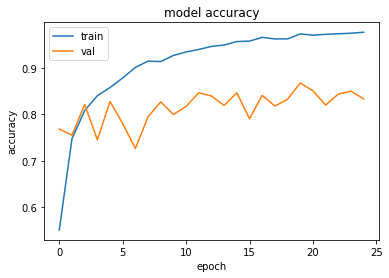

In [75]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


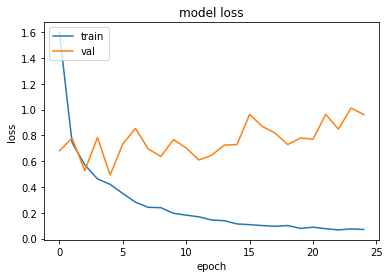

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



## **Predict train model**

In [77]:
predictions = model.predict(X_test)

45/45 [==============================] - 9s 187ms/step


In [78]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% \n({})".format(np.array(df.Name)[predicted_label],
                                100*np.max(predictions_array),
                                np.array(df.Name)[true_label]),
                                color=color)

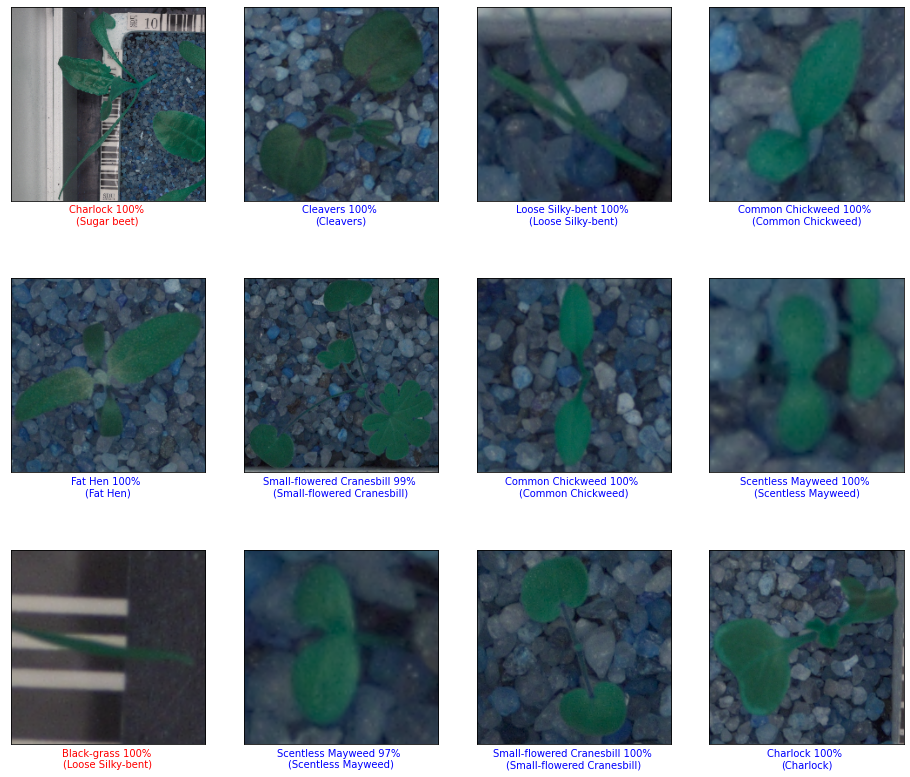

In [79]:
fig=plt.figure(figsize=(16, 20))
rows, cols = 3,4
for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplots_adjust(hspace=-0.5)
plt.show()